## Extension of the 5% pool for all tracers in paper 1

In [17]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
import scipy.stats 

import matplotlib.gridspec as gspec

import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [18]:
sns.set_context('notebook')
sns.set_style('white')

In [19]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 


ptracers_file = '/data/kramosmu/results/TracerExperiments/BARKLEY/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/BARKLEY/run02/ptracersGlob.nc'

In [20]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)
 

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]
 

In [21]:
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

for ii in range(len(records)):
    print(ii,records[ii].name)
select_rec = [0,2,13,15,5,9,18]
    
records2 = [records[0],
            records[13],
            records[15],
            records[5],
            records[3],
            records[9],
            records[7],
            records[16],
            records[18],
            ]
recordsNoC2 = [recordsNoC[0],
               recordsNoC[13],
               recordsNoC[15],
               recordsNoC[5],
               recordsNoC[3],
               recordsNoC[9],
               recordsNoC[7],
               recordsNoC[16],
               recordsNoC[18],
               ]
records2 = records
recordsNoC2 = recordsNoC

0 CNTDIFF_run38
1 CNTDIFF_run37
2 CNTDIFF_run36
3 CNTDIFF_run45
4 CNTDIFF_run73
5 CNTDIFF_run75
6 CNTDIFF_run67
7 CNTDIFF_run51
8 CNTDIFF_run69
9 CNTDIFF_run71
10 3DVISC_run01
11 3DVISC_run02
12 3DVISC_run04
13 3DVISC_run03
14 3DVISC_run05
15 3DVISC_run06
16 LOWER_BF_run01
17 LOW_BF_run01
18 LOWEST_BF_run01
19 LOWEST_BF_run03
20 LOWEST_BF_run05
21 LOWEST_BF_run07
22 LOWEST_BF_run11


In [22]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaPool(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,cont_value,col):
    
    #ax.axvline(X[xind_CS]/1000, color = '0.5', linestyle = '-', linewidth = 1)
    ax.axhline(Y[yind_AS]/1000, color = '0.5', linestyle = ':', linewidth = 1)
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[cont_value], 
                      colors=col, 
                      )
    
    
    #mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[-0.1], 
    #                  colors=col, 
    #                 )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    
def PlotAS(ax,Conc,xsl,zsl,cont_value,col):
    print(np.shape(X[xsl]/1000),np.shape(Z[zsl]), np.shape(Conc))
   
    mesh = ax.contour(X[xsl]/1000,Z[zsl],Conc,[cont_value], 
                      colors=col, 
                      )
    
    ax.plot(X[xsl]/1000,-Depth[yind_AS,xsl],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    
def PlotCS(ax,Conc,yslice,zslice,cont_value,col):
    
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[cont_value], 
                      colors=col, 
                      )
    
    ax.plot(Y[yslice]/1000,-Depth[yslice_CS, xind_CS],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
        
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)

In [23]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
yind_AS = 275
xind_CS = 260

xslice_AS = slice(120,500)
yslice_CS = slice(227,360)
zslice_AS = slice(0,30)

yslice = slice(225,360)
xslice = slice(120,500)

In [24]:
for rec in records2:
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    with Dataset(ptracers_file, 'r') as nbl:
        
        ConcArea, rec.concBOT, Area = BottomConc(np.mean(nbl.variables['Tr1'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
        rec.concAS = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        rec.concCS = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )

done with tracer CNTDIFF run38
done with tracer CNTDIFF run37
done with tracer CNTDIFF run36
done with tracer CNTDIFF run45
done with tracer CNTDIFF run73
done with tracer CNTDIFF run75
done with tracer CNTDIFF run67
done with tracer CNTDIFF run51
done with tracer CNTDIFF run69
done with tracer CNTDIFF run71
done with tracer 3DVISC run01
done with tracer 3DVISC run02
done with tracer 3DVISC run04
done with tracer 3DVISC run03
done with tracer 3DVISC run05
done with tracer 3DVISC run06
done with tracer LOWER_BF run01
done with tracer LOW_BF run01
done with tracer LOWEST_BF run01
done with tracer LOWEST_BF run03
done with tracer LOWEST_BF run05
done with tracer LOWEST_BF run07
done with tracer LOWEST_BF run11


In [25]:
for rec in records2:
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    with Dataset(ptracers_file, 'r') as nbl:
        
        ConcArea, rec.concBOT_ini, Area = BottomConc(nbl.variables['Tr1'][0,:,:,:],hFacC,rA,Depth)
        rec.concAS_ini = np.ma.array(nbl.variables['Tr1'][0,zslice_AS,yind_AS,xslice_AS],
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        rec.concCS_ini = np.ma.array(nbl.variables['Tr1'][0,zslice_AS,yslice_CS,xind_CS],
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )


done with tracer CNTDIFF run38
done with tracer CNTDIFF run37
done with tracer CNTDIFF run36
done with tracer CNTDIFF run45
done with tracer CNTDIFF run73
done with tracer CNTDIFF run75
done with tracer CNTDIFF run67
done with tracer CNTDIFF run51
done with tracer CNTDIFF run69
done with tracer CNTDIFF run71
done with tracer 3DVISC run01
done with tracer 3DVISC run02
done with tracer 3DVISC run04
done with tracer 3DVISC run03
done with tracer 3DVISC run05
done with tracer 3DVISC run06
done with tracer LOWER_BF run01
done with tracer LOW_BF run01
done with tracer LOWEST_BF run01
done with tracer LOWEST_BF run03
done with tracer LOWEST_BF run05
done with tracer LOWEST_BF run07
done with tracer LOWEST_BF run11


In [26]:
for rec, recNoC in zip(records2, recordsNoC2):
    
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            ConcArea, rec.concBOT_anom, Area = BottomConc(np.nanmean(nbl.variables['Tr1'][8:18,:,:,:]-
                                                          noc.variables['Tr1'][8:18,:,:,:],axis=0),hFacC,rA,Depth)
            rec.concAS_anom = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS]-
                                                     noc.variables['Tr1'][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                          mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
            rec.concCS_anom = np.ma.array(np.nanmean(nbl.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS]-
                                                 noc.variables['Tr1'][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                          mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s %s' %(rec.exp_code, rec.run_num) )

done with tracer CNTDIFF run38
done with tracer CNTDIFF run37
done with tracer CNTDIFF run36
done with tracer CNTDIFF run45
done with tracer CNTDIFF run73
done with tracer CNTDIFF run75
done with tracer CNTDIFF run67
done with tracer CNTDIFF run51
done with tracer CNTDIFF run69
done with tracer CNTDIFF run71
done with tracer 3DVISC run01
done with tracer 3DVISC run02
done with tracer 3DVISC run04
done with tracer 3DVISC run03
done with tracer 3DVISC run05
done with tracer 3DVISC run06
done with tracer LOWER_BF run01
done with tracer LOW_BF run01
done with tracer LOWEST_BF run01
done with tracer LOWEST_BF run03
done with tracer LOWEST_BF run05
done with tracer LOWEST_BF run07
done with tracer LOWEST_BF run11


(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)
(380,) (30,) (30, 380)


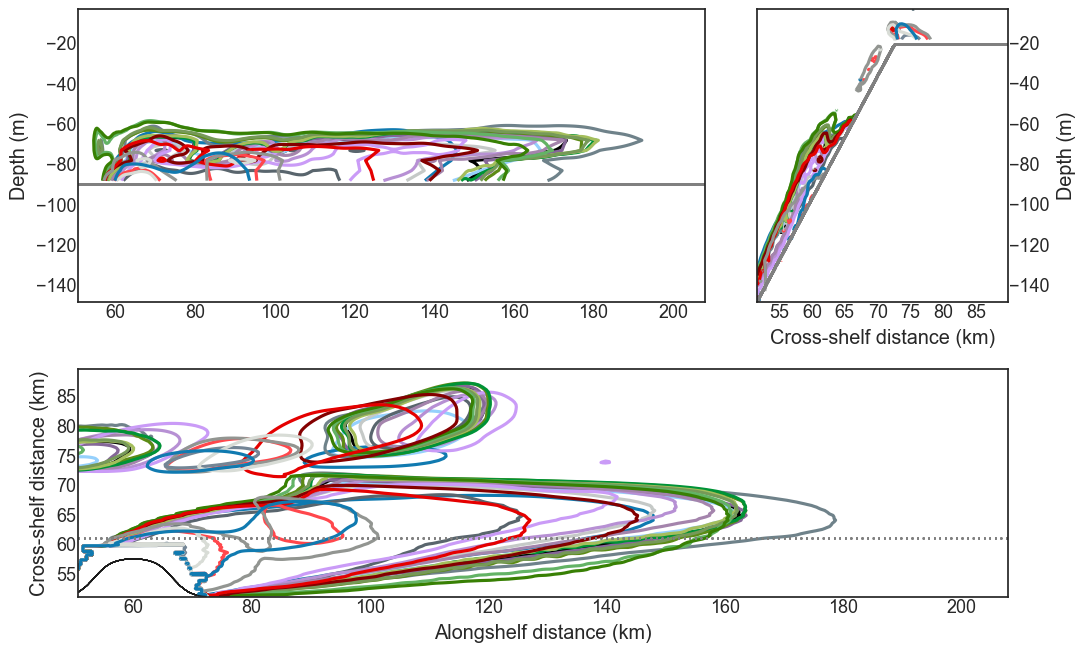

In [27]:
sns.set_context('talk')

f1 = plt.figure(figsize = (12,8)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.12)
gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.12)
    
ax2 = plt.subplot(gs0[1])
ax0 = plt.subplot(gs01[0])
ax1 = plt.subplot(gs01[1])

ii = 0    

CONT = 0.1

for rec in records2:
    PlotPool(ax2,(rec.concBOT_anom)/rec.concBOT_ini,xslice,yslice,CONT,col=sns.xkcd_rgb[rec.color2])

    PlotAS(ax0,(rec.concAS_anom[:,:]/rec.concAS_ini),xslice_AS,zslice_AS,CONT,col=sns.xkcd_rgb[rec.color2])
 
    PlotCS(ax1,(rec.concCS_anom[:,:]/rec.concCS_ini[:,:]),yslice_CS,zslice_AS,CONT,col=sns.xkcd_rgb[rec.color2])


ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
ax1.set_ylabel('Depth (m)')

ax1.legend(ncol=4, bbox_to_anchor=(-0.5,1) )

f1.savefig('pool_vert_10percent_dyn.eps', format='eps',bbox_inches='tight')


In [13]:
print(rec.name)

CNTDIFF_run69


(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)


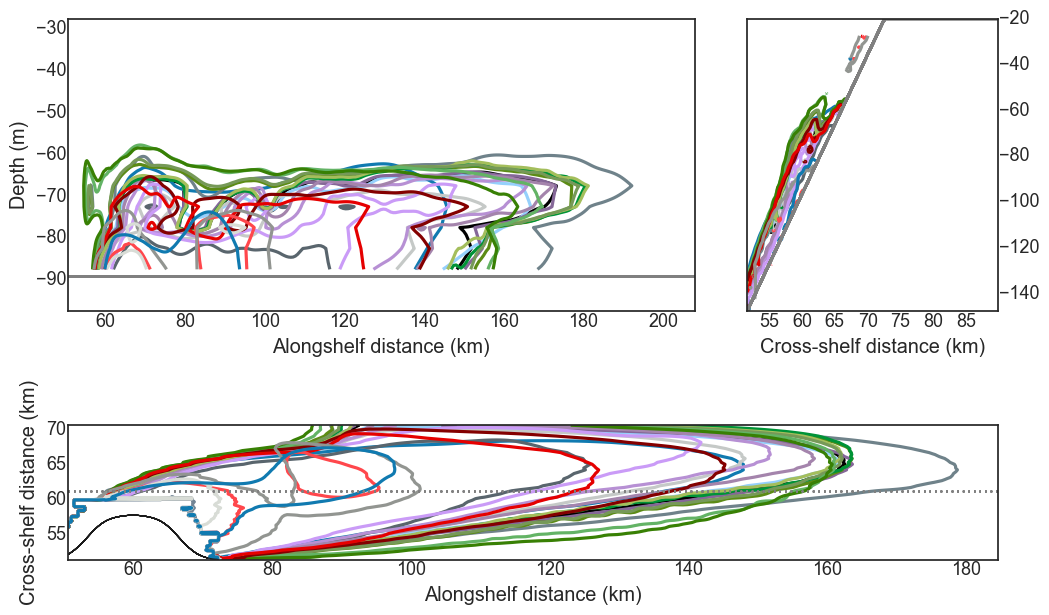

In [28]:
f2 = plt.figure(figsize = (12,8)) # 19.0cm = 7.4in, 115cm = 4.52in
yslice2 = slice(225,310)
xslice2 = slice(120,463)
zslice_AS2 = slice(5,20)
zslice_CS2 = slice(5,30)

gs0 = gspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.12)
gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.12)
    
ax2 = plt.subplot(gs0[1])
ax0 = plt.subplot(gs01[0])
ax1 = plt.subplot(gs01[1])

ii = 0    

CONT = 0.1
for rec in records2:
    PlotPool(ax2,(rec.concBOT_anom)/rec.concBOT_ini,xslice2,yslice2,CONT,col=sns.xkcd_rgb[rec.color2])

    PlotAS(ax0,(rec.concAS_anom[zslice_AS2, :]/rec.concAS_ini[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,col=sns.xkcd_rgb[rec.color2])
 
    PlotCS(ax1,(rec.concCS_anom[zslice_CS2,:]/rec.concCS_ini[zslice_CS2,:]),yslice_CS,zslice_CS2,CONT,col=sns.xkcd_rgb[rec.color2])



ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax0.set_xlabel('Alongshelf distance (km)')

ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
#ax1.set_ylabel('Depth (m)')


f2.savefig('pool_10percent_dyn.eps', format='eps',bbox_inches='tight')


## Bottom concentrations

In [29]:
for rec, recNoC in zip(records2, recordsNoC2):
    ptracers_file = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(rec.exp_code,rec.run_num)
    ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/%s/%s/ptracersGlob.nc' %(recNoC.exp_code,recNoC.run_num)
    rec.BCA = np.empty((nt,ny,nx))
    rec.BC = np.empty((nt,ny,nx))
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            for ii in range(nt):
                rec.BCA[ii,:,:], dummy, rec.AreaTot1 = BottomConc(noc.variables['Tr1'][ii,:,:,:], hFacCNoC,rA,Depth)
                rec.BC[ii,:,:], dummy, rec.AreaTot2 = BottomConc(nbl.variables['Tr1'][ii,:,:,:],hFacCNoC,rA,Depth)


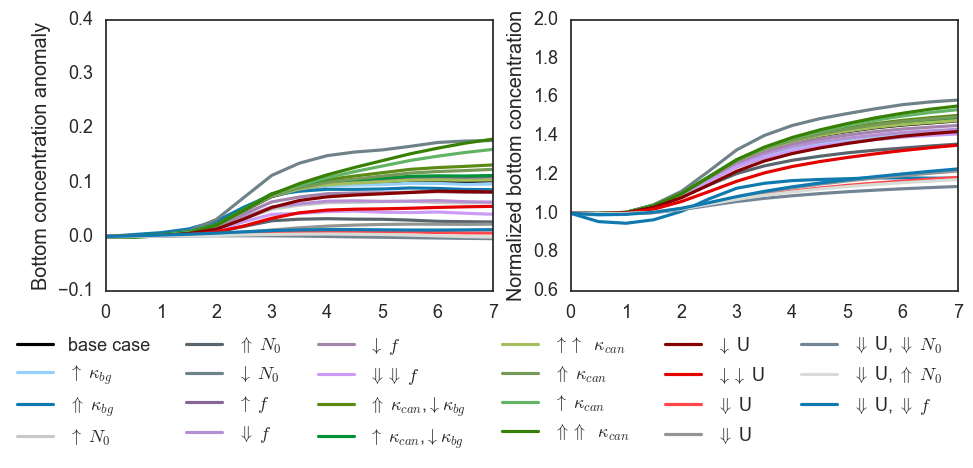

In [30]:
sns.set_context('talk')
fig, (ax1,ax3) = plt.subplots(1,2,figsize=(11,3.5))

for rec in records2:
    ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(rec.BC[:,227:310,120:463],axis=1),axis=1)/
                                (np.nansum(rec.AreaTot2[227:310,120:463])))/
                               (np.nansum(rec.BC[0,227:310,120:463])/(np.nansum(rec.AreaTot2[227:310,120:463]))))-
                               ((np.nansum(np.nansum(rec.BCA[:,227:310,120:463],axis=1),axis=1)/
                                 (np.nansum(rec.AreaTot1[227:310,120:463])))/
                                (np.nansum(rec.BCA[0,227:310,120:463])/(np.nansum(rec.AreaTot1[227:310,120:463]))))),
             color=sns.xkcd_rgb[rec.color2], label=rec.label2)

    ax3.plot(np.arange(19)/2, ((np.nansum(np.nansum(rec.BC[:,227:310,120:463],axis=1),axis=1)/(np.nansum(rec.AreaTot2[227:310,120:463])))/
            (np.nansum(rec.BC[0,227:310,120:463])/(np.nansum(rec.AreaTot2[227:310,120:463])))),
             color=sns.xkcd_rgb[rec.color2])

ax1.set_xlim(0,7)
#ax2.set_xlim(0,7)
ax3.set_xlim(0,7)

ax1.set_ylim(-0.1, 0.4)
ax3.set_ylim(0.6, 2)

ax1.legend(bbox_to_anchor=(2.2, -0.1), ncol=6)
ax3.set_ylabel('Normalized bottom concentration')
ax1.set_ylabel('Bottom concentration anomaly')
#ax2.set_ylabel('Area ( $10^9$ m$^2$)')
fig.savefig('bottom_conc_Dyn.eps', format='eps',bbox_inches='tight')



(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)


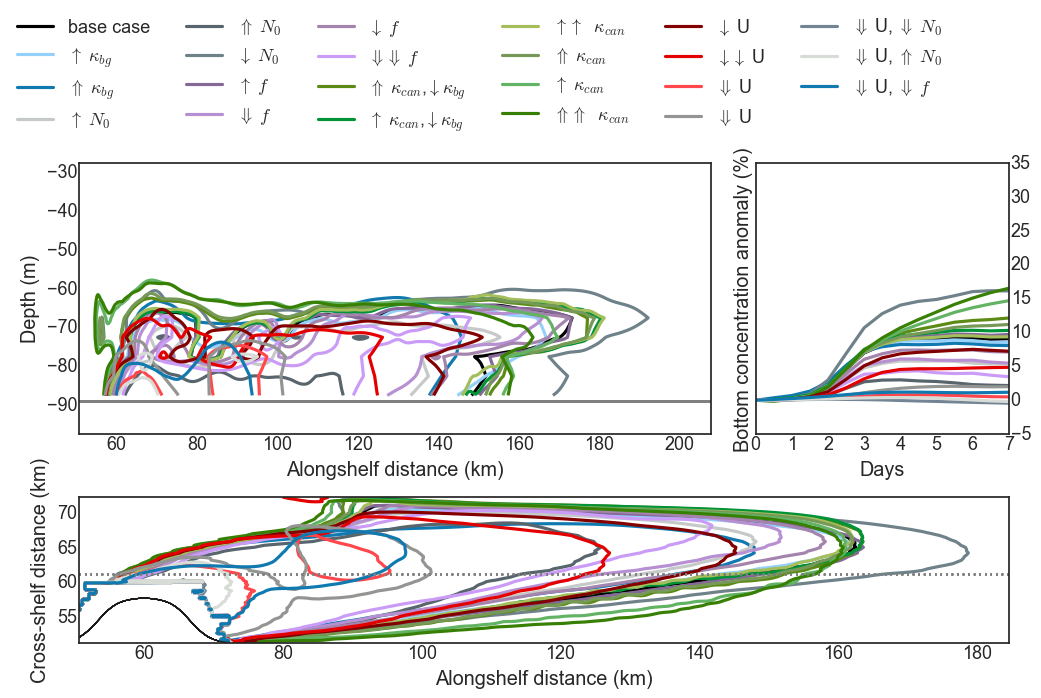

In [39]:
f1 = plt.figure(figsize = (12,7)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.0)
gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.1)
    
ax2 = plt.subplot(gs0[1])
ax0 = plt.subplot(gs01[0])
ax1 = plt.subplot(gs01[1])

ii = 0    

CONT = 0.1

yslice2 = slice(225,315)
xslice2 = slice(120,463)
zslice_AS2 = slice(5,20)
zslice_CS2 = slice(5,30)

for rec in records2:
    PlotPool(ax2,(rec.concBOT_anom)/rec.concBOT_ini,xslice2,yslice2,CONT,sns.xkcd_rgb[rec.color2])

    PlotAS(ax0,(rec.concAS_anom[zslice_AS2, :]/rec.concAS_ini[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,
           sns.xkcd_rgb[rec.color2])
 
    ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                                (np.nansum(rec.AreaTot2[227:315,120:463])))/
                               (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                               ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                                 (np.nansum(rec.AreaTot1[227:315,120:463])))/
                                (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))*100,
             color=sns.xkcd_rgb[rec.color2], label=rec.label2)

ax0.set_ylabel('Depth (m)')
ax0.set_xlabel('Alongshelf distance (km)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Days')
ax1.set_ylabel('Bottom concentration anomaly (%)', labelpad=2)
ax1.yaxis.set_ticks_position("right")

ax1.tick_params(axis='x', pad=1)
ax1.tick_params(axis='y', pad=1.4)
ax1.legend(ncol=6, bbox_to_anchor=(0.8,1.6) )

ax1.set_xlim(0,7)
ax1.set_ylim(-5,35)

f1.savefig('pool_10percent_dyn.eps', format='eps',bbox_inches='tight')


(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)
(380,) (15,) (15, 380)


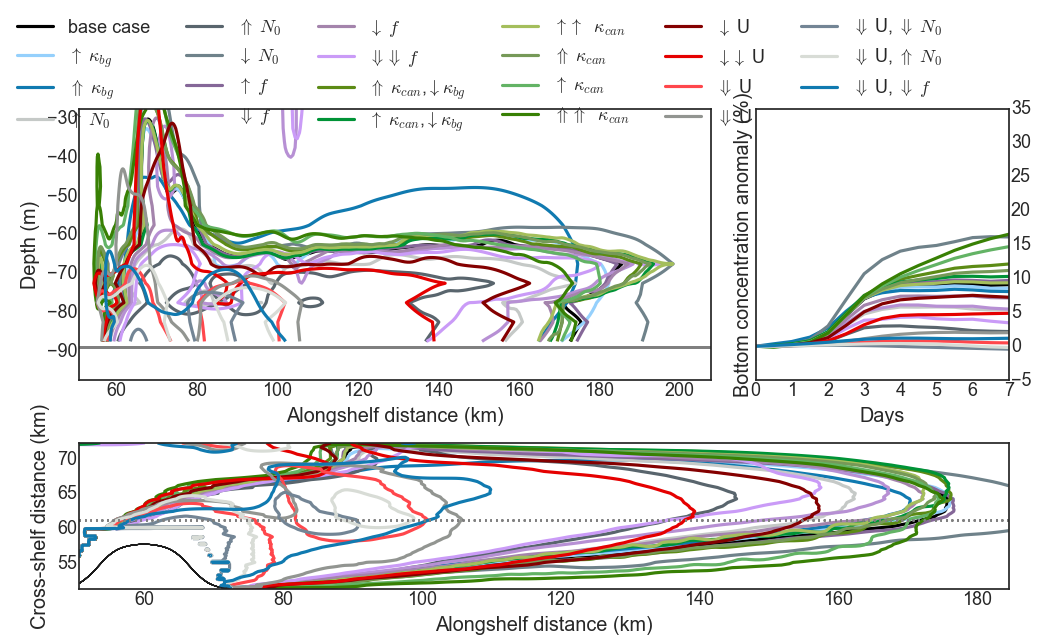

In [40]:
f1 = plt.figure(figsize = (12,7)) # 19.0cm = 7.4in, 115cm = 4.52in

gs0 = gspec.GridSpec(2, 1, height_ratios=[1,1], hspace=0.0)
gs01 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0],width_ratios=[1,0.4], wspace=0.1)
    
ax2 = plt.subplot(gs0[1])
ax0 = plt.subplot(gs01[0])
ax1 = plt.subplot(gs01[1])

ii = 0    

CONT = 0.05
yslice2 = slice(225,315)
xslice2 = slice(120,463)
zslice_AS2 = slice(5,20)
zslice_CS2 = slice(5,30)

for rec in records2:
    PlotPool(ax2,(rec.concBOT_anom)/rec.concBOT_ini,xslice2,yslice2,CONT,sns.xkcd_rgb[rec.color2])

    PlotAS(ax0,(rec.concAS_anom[zslice_AS2, :]/rec.concAS_ini[zslice_AS2, :]),xslice_AS,zslice_AS2,CONT,
           sns.xkcd_rgb[rec.color2])
 
    ax1.plot(np.arange(19)/2, (((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                                (np.nansum(rec.AreaTot2[227:315,120:463])))/
                               (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                               ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                                 (np.nansum(rec.AreaTot1[227:315,120:463])))/
                                (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))*100,
             color=sns.xkcd_rgb[rec.color2], label=rec.label2)

ax0.set_ylabel('Depth (m)')
ax0.set_xlabel('Alongshelf distance (km)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Days')
ax1.set_ylabel('Bottom concentration anomaly (%)', labelpad=2)
ax1.yaxis.set_ticks_position("right")

ax1.tick_params(axis='x', pad=1)
ax1.tick_params(axis='y', pad=1.5)
ax1.legend(ncol=6, bbox_to_anchor=(0.8,1.4) )

ax1.set_xlim(0,7)
ax1.set_ylim(-5,35)

f1.savefig('pool_5percent_dyn.eps', format='eps',bbox_inches='tight')


In [69]:
for rec in records2:
    print (rec.name)

PhiTr =[328449.382343,
        322657.124435,
        254680.70265,
        211062.407598,
        105091.077469,
        518156.879498,
        347015.65351,
        168870.455904,
        253853.406292,
        48936.7983215,
        325767.295363,
        324835.676255,
        326571.50224,
        325704.396546,
        327056.712197,
        338326.177119,
        235782.113464,
        154057.139717,
        32482.3458203,
        47289.3372349,
        14490.4718936,
        18745.5176288,
        21371.3101944,
       ]

PhiTrNoKv =[328449.382343,
            322657.124435,
            254680.70265,
            211062.407598,
            105091.077469,
            518156.879498,
            347015.65351,
            168870.455904,
            253853.406292,
            48936.7983215,
            235782.113464,
            154057.139717,
            32482.3458203,
            47289.3372349,
            14490.4718936,
            18745.5176288,
            21371.3101944,
       ]

ind_records_noKv = [0,1,2,3,4,5,6,7,8,9,16,17,18,19,20,21,22]

records_noKv = []
for ind in ind_records_noKv:
    records_noKv.append(records[ind])

BAC_array = np.empty(len(records2))
BAC_array_noKv = np.empty(len(records_noKv))


for rec,ii in zip(records2, range(len(records2))):
    BAC_array[ii]=(((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot2[227:315,120:463])))/
                    (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                   ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot1[227:315,120:463])))/
                    (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))[14]*100
    
# Array without Kv runs
for rec, ii in zip(records_noKv, range(len(records_noKv))) :
    BAC_array_noKv[ii]=(((np.nansum(np.nansum(rec.BC[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot2[227:315,120:463])))/
                    (np.nansum(rec.BC[0,227:315,120:463])/(np.nansum(rec.AreaTot2[227:315,120:463]))))-
                   ((np.nansum(np.nansum(rec.BCA[:,227:315,120:463],axis=1),axis=1)/
                     (np.nansum(rec.AreaTot1[227:315,120:463])))/
                    (np.nansum(rec.BCA[0,227:315,120:463])/(np.nansum(rec.AreaTot1[227:315,120:463])))))[14]*100
    

CNTDIFF_run38
CNTDIFF_run37
CNTDIFF_run36
CNTDIFF_run45
CNTDIFF_run73
CNTDIFF_run75
CNTDIFF_run67
CNTDIFF_run51
CNTDIFF_run69
CNTDIFF_run71
3DVISC_run01
3DVISC_run02
3DVISC_run04
3DVISC_run03
3DVISC_run05
3DVISC_run06
LOWER_BF_run01
LOW_BF_run01
LOWEST_BF_run01
LOWEST_BF_run03
LOWEST_BF_run05
LOWEST_BF_run07
LOWEST_BF_run11


slope = 2.927, intercept = 0.001, r_value = 0.982, p_value = 0.000, std_err = 0.146


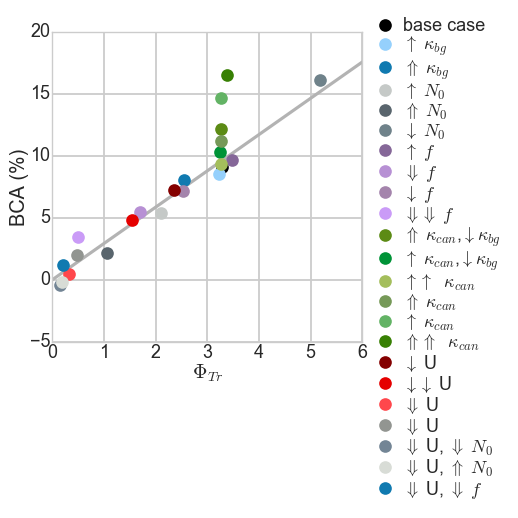

In [79]:
sns.set_context('talk')
sns.set_style('whitegrid')
Hs = 147.5 # m, I will plot the non dimensional derivative C'=C/Co, Z'=Z/Hs, 
           # so \partialC'/\partialZ' = Hs/Co \partialC/\partial Z

fig,ax1 = plt.subplots(1,1,figsize=(4,4))


# Linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.array(PhiTrNoKv)/1E5,BAC_array_noKv)
print('slope = %1.3f, intercept = %1.3f, r_value = %1.3f, p_value = %1.3f, std_err = %1.3f' %(
        slope, intercept, r_value, p_value, std_err))

# Plot
ax1.plot(np.linspace(-0,6,20), ((slope)*np.linspace(0,6,20))+(np.ones(20)*intercept),'-', color='0.7')

for ii, rec in zip(range(len(PhiTr)), records2):
    ax1.plot(PhiTr[ii]/1E5,BAC_array[ii], 'o', color=sns.xkcd_rgb[rec.color2],
             label=rec.label2)

ax1.set_ylabel('BCA (%)', labelpad=0.5)
ax1.set_xlabel(r'$\Phi_{Tr}$', labelpad=0)

ax1.tick_params(axis='y', pad=1.5)
ax1.tick_params(axis='x', pad=1.8)

#ax1.set_xlim(-3.6,1)

ax1.legend(bbox_to_anchor=(1.5,1.1), ncol = 1, handletextpad=0,labelspacing=0, columnspacing=0 )
fig.savefig('BCA_vs_PhiTr.eps', format='eps', bbox_inches='tight')
